# Project Overview

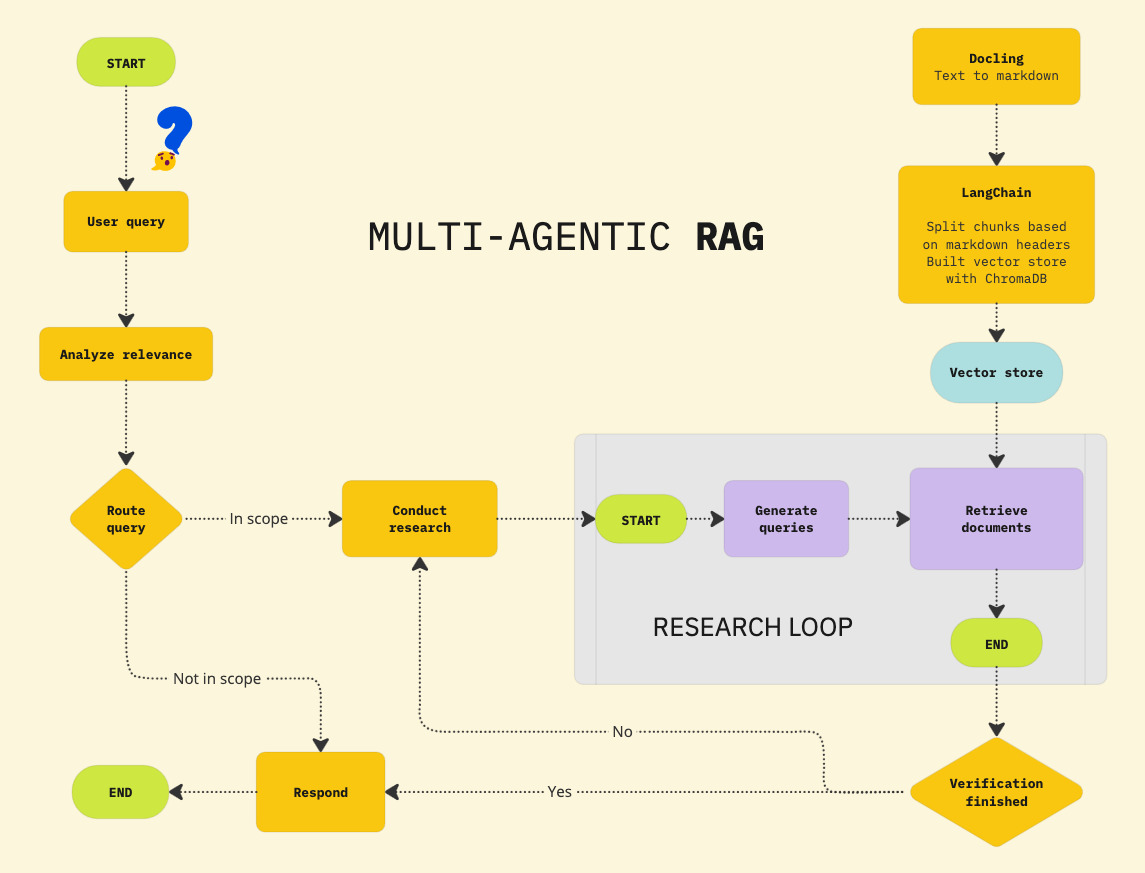

## 1 - User query processing & relevance analysis
* The system starts when a user submits a question about their uploaded document(s)
* Before retrieving any data, DocChat first analyzes query relevance to determine if the question is within the scope of the uploaded content

## 2 - Routing & query categorization
* The query is routed through an intelligent agent that decides whether the system can answer it using the document(s):
 * In scope: Proceed with document retrieval and response generation.
 * Not in scope: Inform the user that the question cannot be answered based on the provided documents, preventing hallucinations.

## 3 - Multi-agent research & document retrieval
* If the query is relevant, DocChat retrieves relevant document sections from a hybrid search system:
 - Docling converts the document into a structured Markdown format for better chunking
* LangChain splits the document into logical chunks based on headers and stores them in ChromaDB (a vector store)
* The retrieval module searches for the most contextually relevant document chunks using BM25 and vector search

## 4 - Answer generation & verification loop
Conduct research:

* The research agent generates an initial answer based on retrieved content
* A sub-process starts where queries are dynamically generated for more precise retrieval

Verification process:

* The verification agent cross-checks the generated response against the retrieved content
* If the response is fully supported, the system finalizes and returns the answer
* If verification fails (e.g., hallucinations, unsupported claims), the system re-runs the research step until a verifiable response is found
## 5 - Response finalization
* After verification is complete, DocChat returns the final response to the user
* The workflow ensures that each answer is sourced directly from the provided document(s), preventing fabrication or unreliable outputs

# Build vector database

## 1. Document parsing with Docling

Processing PDFs with complex structures, tables, and intricate layouts requires careful selection of a reliable document parsing tool. Many libraries struggle with accuracy when dealing with nested tables, multi-column formats, or scanned PDFs, often resulting in misaligned text, missing data, or broken layouts.

To overcome these challenges, DocChat leverages [Docling](https://github.com/DS4SD/docling)—an open-source document processing library designed for high-precision parsing and structured data extraction.

### Why Docling?
* Accurate table & layout parsing: Recognizes complex table structures, reading sequences, and multi-column layouts
* Multi-format support: Reads and exports documents in Markdown, JSON, PDF, DOCX, PPTX, XLSX, HTML, AsciiDoc, and images
* OCR for scanned PDFs: Extracts text from scanned documents using optical character recognition (OCR)
* Seamless integration with LangChain: Enables structured chunking for better retrieval and vector search in ChromaDB

## 2. Building a vector database with ChromaDB

Once documents have been parsed and structured using Docling, the next step is to efficiently store and retrieve relevant document chunks. This is where ChromaDB comes into play—a high-performance vector database optimized for fast and accurate similarity search

### What is Chroma DB?
Chroma DB is an open-source vector database optimized for fast and scalable similarity search. It enables efficient storage, retrieval, and ranking of document embeddings, making it a key component of RAG workflows.

### Why ChromaDB?
* Blazing-fast vector search: Finds the most relevant document chunks in milliseconds
* Persistent storage: Keeps embeddings saved for reuse across sessions
* Seamless LangChain integration: Works natively with LangChain for retrieval-augmented generation (RAG)
* Scalable and lightweight: Handles millions of embeddings efficiently without complex infrastructure



In [ ]:
# === Document Processor (file_handler.py)====
import os
import hashlib
import pickle
from datetime import datetime, timedelta
from pathlib import Path
from typing import List
from docling.document_converter import DocumentConverter
from langchain_text_splitters import MarkdownHeaderTextSplitter
from config import constants
from config.settings import settings
from utils.logging import logger


#class responsible for handling document parsing, caching, and chunking.

# The DocumentProcessor class ensures efficient document parsing and retrieval by leveraging:
# Docling for structured content extraction
# ChromaDB-compatible chunking for vector search
# A caching system to avoid redundant processing
class DocumentProcessor:

    #initialize document processor with 1) a predefined header structure for markdown-based chunking. 2) A cache directory for storing
    #document chunks 3) ensures cache directory exists.
    def __init__(self):
        self.headers = [("#", "Header 1"), ("##", "Header 2")]
        self.cache_dir = Path(settings.CACHE_DIR)
        self.cache_dir.mkdir(parents=True, exist_ok=True)
        
    #Purpose: ensures that the total size of uploaded files doesn't exceed a predefined limit
    #How it works: 1) Computes the total size of all uploaded files 2) Compares the total size against a fixed max total size
    #              3) Raises a 'ValueError' if the limit is exceeded.
    def validate_files(self, files: List) -> None:
        """Validate the total size of the uploaded files."""
        total_size = sum(os.path.getsize(f.name) for f in files)
        if total_size > constants.MAX_TOTAL_SIZE:
            raise ValueError(f"Total size exceeds {constants.MAX_TOTAL_SIZE//1024//1024}MB limit")

    #Purpose: Handles the entire document processing pipeline, including caching and deduplication
    #How it works:
    # 1) Validates the uploaded files
    # 2) Generate a hash for each file's content to check if it has been processed before
    # 3) If cached, load data from cache. Else process the file using _process_file() method and store results in cache.
    # 4) Ensures that no duplicate chunks are stored across multiple files.
    # 5) Returns all file chunks

    def process(self, files: List) -> List:
        """Process files with caching for subsequent queries"""
        self.validate_files(files)
        all_chunks = []
        seen_hashes = set()
        
        for file in files:
            try:
                # Generate content-based hash for caching
                with open(file.name, "rb") as f:
                    file_hash = self._generate_hash(f.read())
                
                cache_path = self.cache_dir / f"{file_hash}.pkl"
                
                #check if file is already cached and load from cache
                if self._is_cache_valid(cache_path):
                    logger.info(f"Loading from cache: {file.name}")
                    chunks = self._load_from_cache(cache_path)

                #if not cached, process the file and store in cache
                else:
                    logger.info(f"Processing and caching: {file.name}")
                    chunks = self._process_file(file) #split file into structured text chunks
                    self._save_to_cache(chunks, cache_path)
                
                # Deduplicate chunks across files
                for chunk in chunks:
                    chunk_hash = self._generate_hash(chunk.page_content.encode()) #generate unique hash per chunk
                    if chunk_hash not in seen_hashes:
                        all_chunks.append(chunk)
                        seen_hashes.add(chunk_hash)
                        
            except Exception as e:
                logger.error(f"Failed to process {file.name}: {str(e)}")
                continue
                
        logger.info(f"Total unique chunks: {len(all_chunks)}")
        return all_chunks

    #Purpose: Converts the documents into Markdown and splits it into structured text chunks
    def _process_file(self, file) -> List:
        """Original processing logic with Docling"""
        #skip unsupported files
        if not file.name.endswith(('.pdf', '.docx', '.txt', '.md')):
            logger.warning(f"Skipping unsupported file type: {file.name}")
            return []

        #uses Docling 'DocumentConverter' to convert file to Markdown
        converter = DocumentConverter()
        markdown = converter.convert(file.name).document.export_to_markdown()

        #Split extracted Markdown text into chunks
        splitter = MarkdownHeaderTextSplitter(self.headers)
        return splitter.split_text(markdown)

    #Purpose: Generate a unique SHA-256 hash from doucment content
    def _generate_hash(self, content: bytes) -> str:
        return hashlib.sha256(content).hexdigest()

    #Save processed document chunks in a pickle file for future use
    def _save_to_cache(self, chunks: List, cache_path: Path):
        
        #store chunks with timestanp for expiration checking
        with open(cache_path, "wb") as f:
            pickle.dump({
                "timestamp": datetime.now().timestamp(),
                "chunks": chunks
            }, f)

    #Purpose: Load cached document chunks from a previously processed file
    def _load_from_cache(self, cache_path: Path) -> List:
        with open(cache_path, "rb") as f:
            data = pickle.load(f)
        return data["chunks"]

    #Purpose: Check if cached file is stille valid (not expired)
    def _is_cache_valid(self, cache_path: Path) -> bool:
        if not cache_path.exists():
            return False
        
        #compare modification timestamp of cached file against CACHE_EXPIRE_DAYS
        #if file is older than expiration threshold, it is considered invalid.
        cache_age = datetime.now() - datetime.fromtimestamp(cache_path.stat().st_mtime)
        return cache_age < timedelta(days=settings.CACHE_EXPIRE_DAYS)

# Graph Structure for this Project


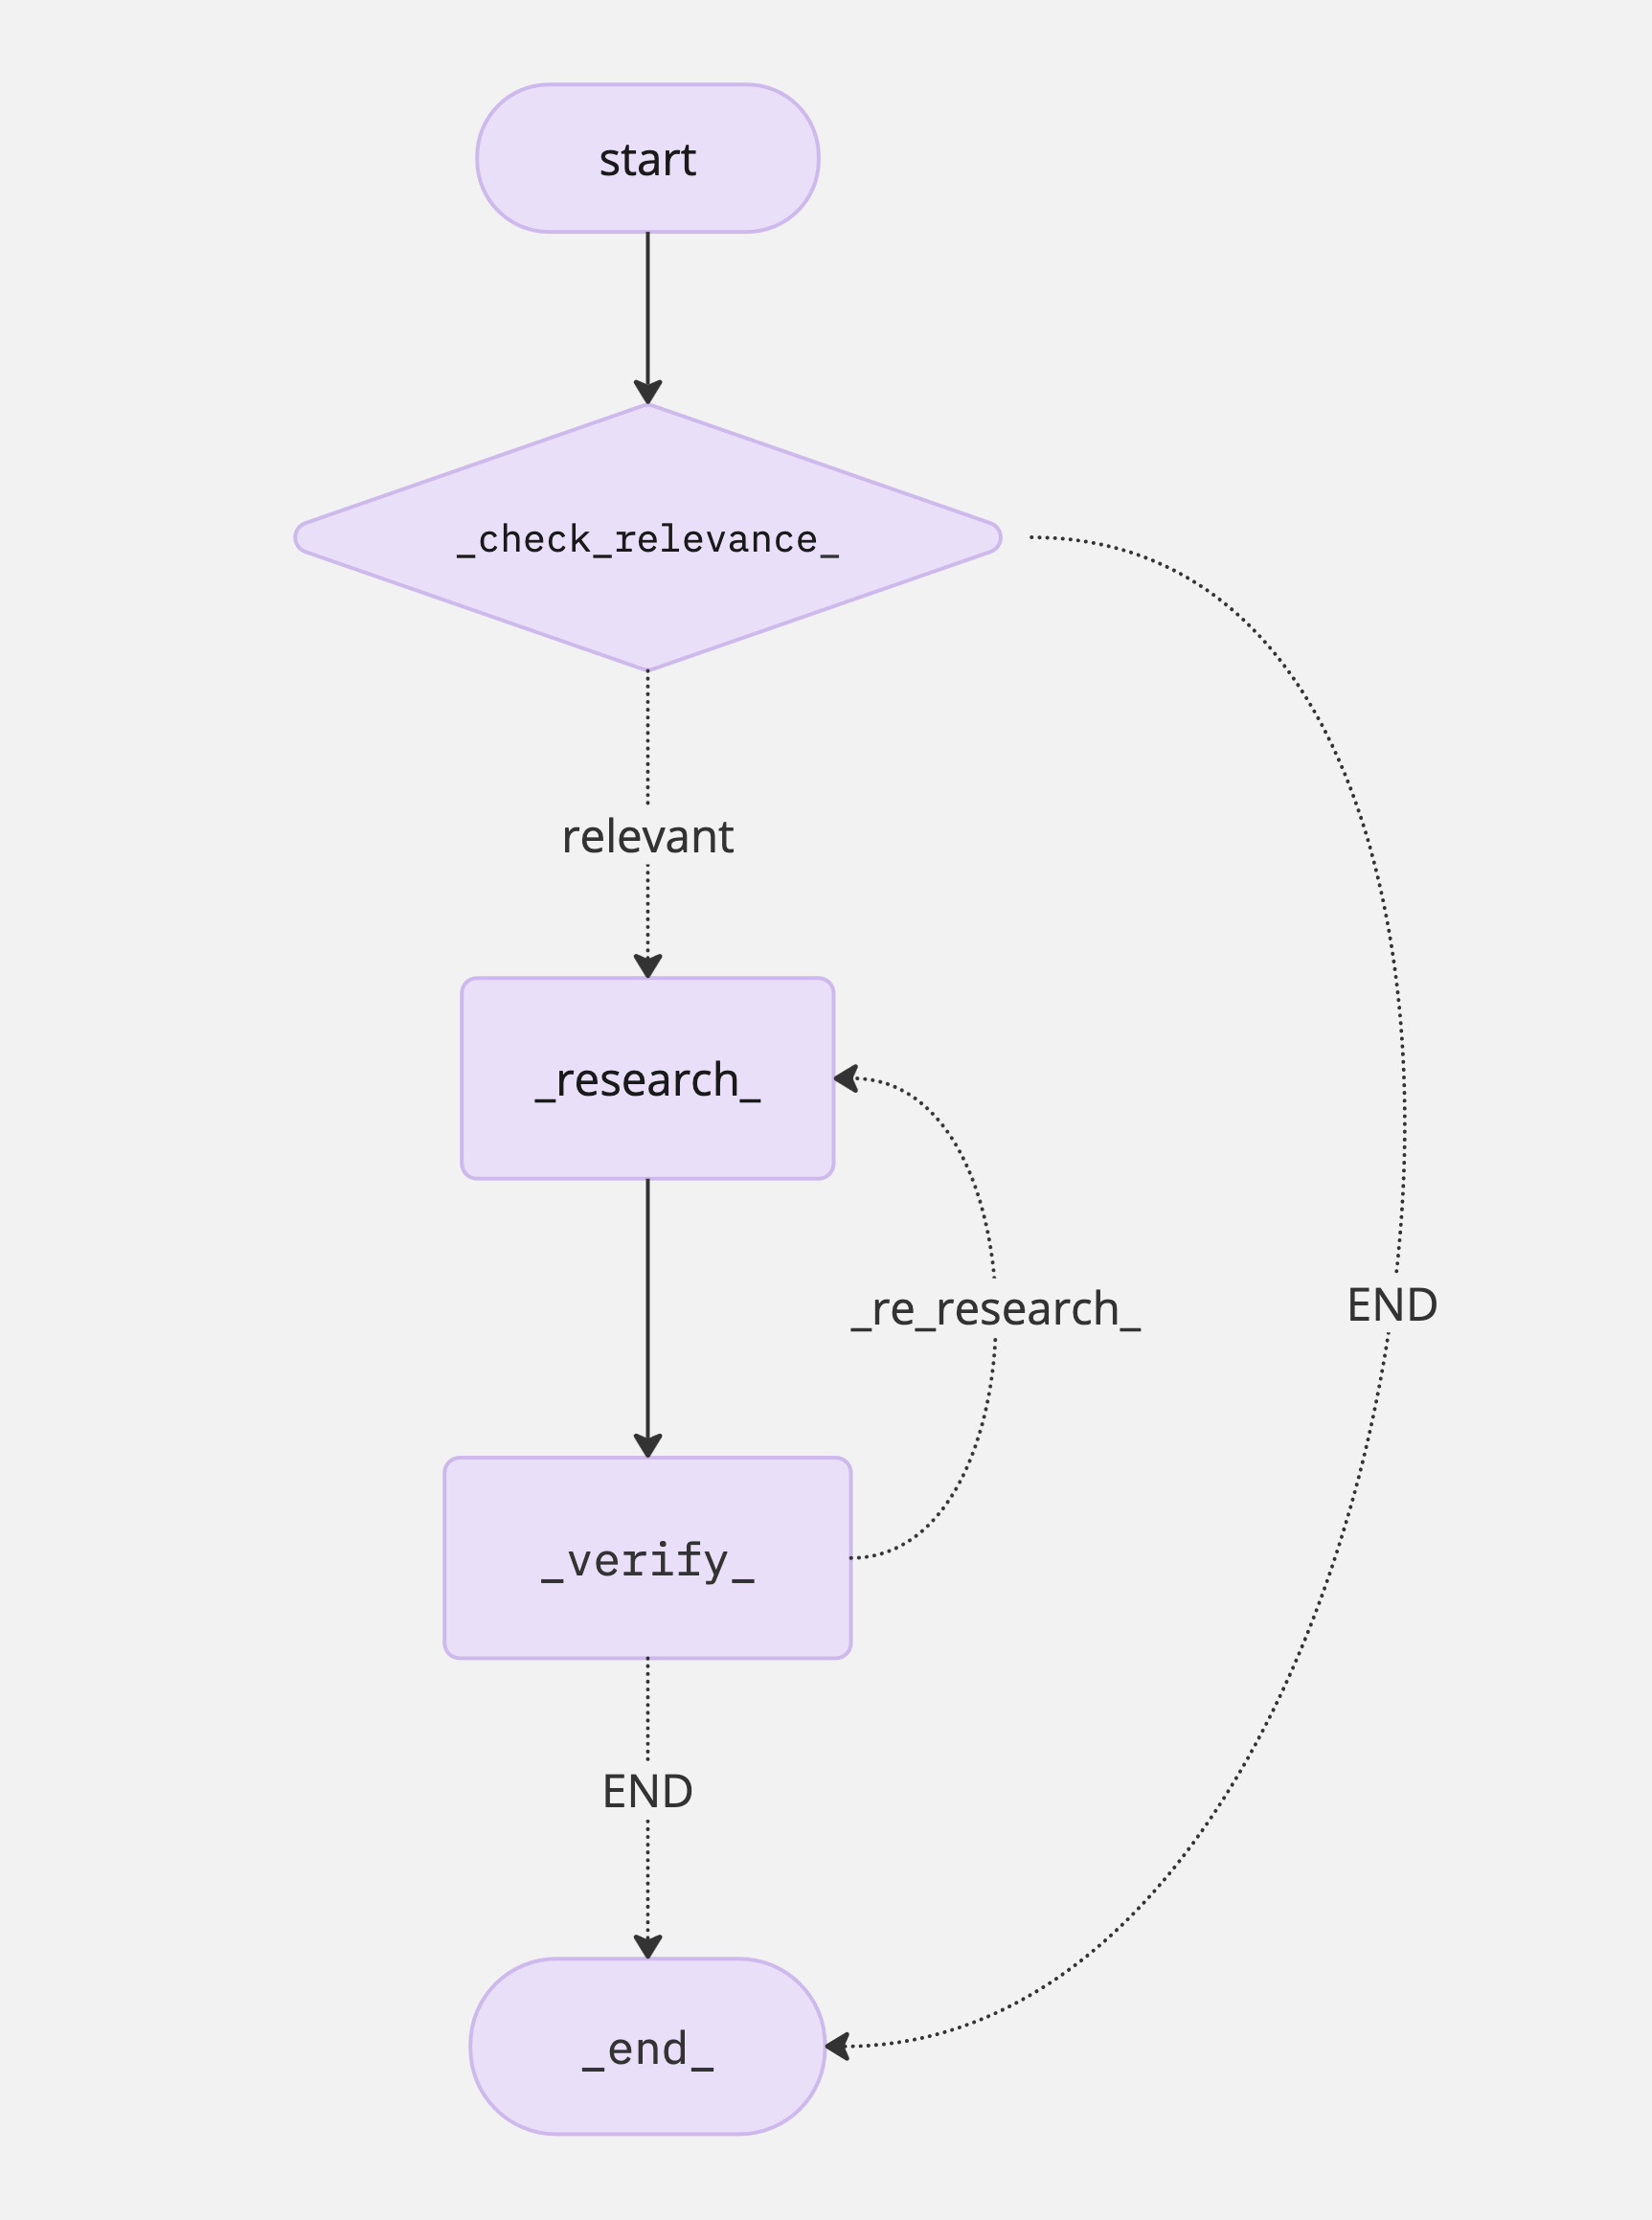

The AgentWorkflow class constructs the multi-agent system using LangGraph's **StateGraph**, ensuring a structured approach to information retrieval and verification.

### Workflow breakdown

1. **Check relevance** – The RelevanceChecker determines if the query can be answered based on the retrieved documents.

* If relevant → Proceed to research
* If irrelevant → Terminate workflow

2. **Research step** – The ResearchAgent generates a draft answer using relevant documents.

3. **Verification step** – The VerificationAgent assesses the draft answer for accuracy and relevance

4. **Decision making** - Based on verification
* If the answer lacks support -> Re-research and refine
* If verified -> End workflow

# DocChat application: Bringing RAG-based question answering to life


## How the application works
The app follows a structured workflow:

* 1. Users upload documents or select a predefined example.
* 2. The hybrid retriever extracts relevant document chunks.
* 3. The multi-agent system (LangGraph) processes the query.
* 4. The AI generates an answer & a verification report.
* 5. The response is displayed in the Gradio interface.


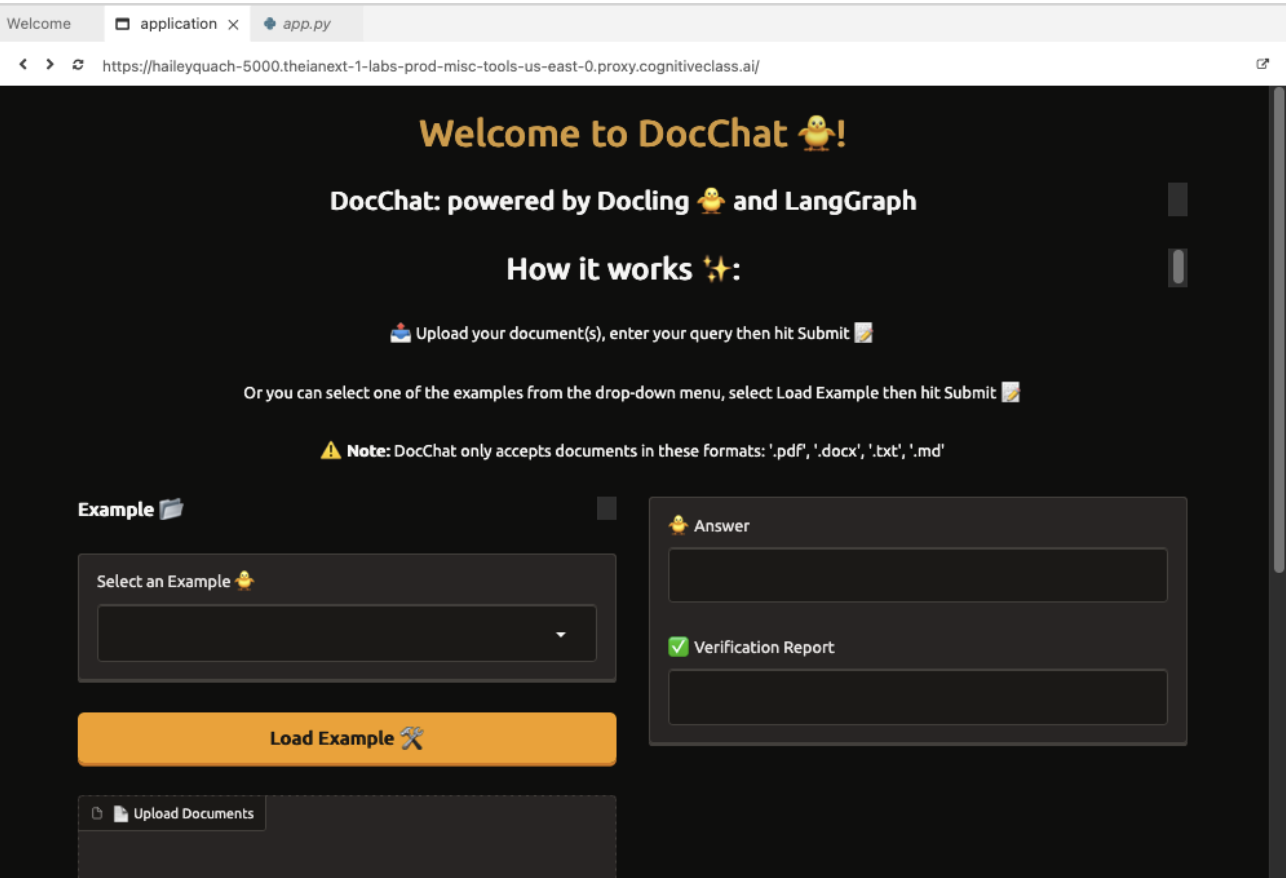

# Note:
* Every agent e.g ResearchAgent always return a dictionary where the keys are found in the AgentState. This allows the State to be updated with the output of an Agent or Node in the Graph.
* Defining the AgentState is a critical step that requires thought, as it captures all relevant information that will be flowing fron Node (Agent) to Node (Agent) in a workflow.
* Each Agent uses a different LLM e.g ResearchAgent to generate initial draft uses "meta-llama/llama-3-2-90b-vision-instruct", while VerificationAgent uses "ibm/granite-4-h-small". This means that, choice a model for each agent is based on the role of the Agent and therefore, should be choosen carefully and strategically. I will look into these models and see exactly what they offer.
* Each Agent is defined as a class and the class is often initialized with the model to be used in the __init__() method.
* Each Agent should always have a Sanitize_response() method for cleaning response generated by LLM.
* Each Agent should also have a generate_prompt() method that takes the query and context (docs) as inputs and builds a complete prompt consisting of the instructions for the LLM.
* A function to parse or format LLM response is always needed e.g _parse_verification_response()_. This is because LLM response is not generated in a nice way to be printed to user.
* In each Agent Class, we have supporting methods and one main method that combines all supporting methods forming a pipeline. This is useful because, when we initialize the class object in another py file, we only need to invoke or call only that main method from that class it will automatically execute the other methods. So it's standard procedure to limit number of methods to be invoked in a class.
* It is good practice to always have a configurations or settings file where you define all constants and paths and other parameters in your code. This ensures it's easy to make changes in one place.e.g settings.py.


## Pull and Test Ollama Embeddings Model

In the original code, IBM Watson embeddings is used. In this local version, I will use Ollama embeddings specifically, "Nomic-embed-text". LangChain already supports or provides built-in OllamaEmbeddings integration. 
* Install Ollama on the python virtual environment _pip install ollama_
* Pull the embeddings models using _ollama pull nomic-embed-text_


In [4]:
from langchain.embeddings import OllamaEmbeddings

emb = OllamaEmbeddings(model="nomic-embed-text")

# Get embeddings for a list of texts
texts = ["Hello world!", "Another sentence is cooler"]
vectors = emb.embed_documents(texts)

print("Vector for first text:", vectors[0][:10])
print("Vector for second text:", vectors[1][:10])
print("Embedding length:", len(vectors[0]))



Vector for first text: [-0.030617523938417435, 0.6553830504417419, -3.985818862915039, -0.13785088062286377, 0.14976680278778076, 0.6044387817382812, -0.15589171648025513, -0.20370130240917206, -0.5570294857025146, -1.3209190368652344]
Vector for second text: [0.6076087951660156, 0.4492245018482208, -3.6846823692321777, -0.30052754282951355, 0.07452882081270218, 0.002521336078643799, 0.10518753528594971, 0.15260560810565948, -1.3241651058197021, -1.3304572105407715]
Embedding length: 768


In [2]:
import ollama

text_to_embed = "This is a simple sentence to embed."
response = ollama.embeddings(
    model="nomic-embed-text",
    prompt=text_to_embed,
)

embedding_vector = response["embedding"]
print("Embedding length:", len(embedding_vector))
print("First 10 dimensions:", embedding_vector[:10])


Embedding length: 768
First 10 dimensions: [0.6034806370735168, 0.8066565990447998, -3.0430479049682617, -1.1265382766723633, 1.2353172302246094, -0.6934847235679626, 0.7545576095581055, -0.29499003291130066, -0.30516988039016724, -1.8156508207321167]


## Pull, Test and Use Ollama Llama3.2 model
* The aim here is to replace the 'meta-llama/llama-3-2-90b-vision-instruct' model used in the research_agent.py file to generate initial response.
* By using Ollama "llama3.2-vision:11b" model, we can run the LLM locally and generate content.
* Pull the model first. Note ollama must be running. _ollama pull llama3.2-vision:11b_

In [8]:
#Example with Text Only
import ollama

# Model name must match what you've installed
model_name = "llama3.2-vision:11b"

# Example prompt (text only)
prompt_text = "Explain how a black hole works in simple terms."

print("Running text-only prompt…")
response = ollama.chat(
    model=model_name,
    messages=[
        {"role": "user", "content": prompt_text}
    ],
    options={"temperature": 0.3, "num_predict": 200}
)

print("Model response:\n", response)


Running text-only prompt…
Model response:
 model='llama3.2-vision:11b' created_at='2026-02-02T00:25:07.407953Z' done=True done_reason='length' total_duration=25370950333 load_duration=7308131458 prompt_eval_count=20 prompt_eval_duration=4031545208 eval_count=200 eval_duration=13881013999 message=Message(role='assistant', content="Black holes are fascinating and complex objects, but I'll try to break it down in simple terms:\n\n**What is a black hole?**\nA black hole is a region in space where the gravitational pull is so strong that nothing, including light, can escape. It's like a super-powerful vacuum cleaner that sucks up everything that gets too close.\n\n**How is it formed?**\nA black hole is created when a massive star (like a giant star) runs out of fuel and dies. The star collapses under its own gravity, causing a massive amount of matter to be compressed into an incredibly small space. This compression creates an intense gravitational field that warps the fabric of space and t

In [16]:
## Example with Image

model_name = "llama3.2-vision:11b"
image_path = "test/sample.png"  # replace with your image file

response_with_image = ollama.chat(
    model=model_name,
    messages=[
        {
            "role": "user",
            "content": "Extract the text in the image as accurately as possible.",
            "images": [image_path]
        }
    ],
    options={"temperature": 0.3, "num_predict": 200}
)

print("Vision model response:\n", response_with_image)



Vision model response:
 model='llama3.2-vision:11b' created_at='2026-02-02T00:36:39.727029Z' done=True done_reason='length' total_duration=34469177666 load_duration=3823943166 prompt_eval_count=21 prompt_eval_duration=690861291 eval_count=200 eval_duration=15434766626 message=Message(role='assistant', content='The image presents a page from a technical document, likely a research paper or academic article, focusing on optimized table tokenization for table structure recognition. The page is divided into three sections: "Hyper Parameter Optimization," "Quantitative Results," and a table.\n\n**Section 1: Hyper Parameter Optimization**\n\nThis section discusses the optimization of hyperparameters for the table tokenization model. It explains that the model was trained on a single core with an AMD EPYC 7763 CPU at 2.45 GHz. The section also mentions that the model achieved the same TED score and slightly better mAP scores compared to HTML, but with a 2x speedup in inference runtime over HT

In [17]:
llm_response = response_with_image['message']['content'].strip()
print(f"Raw LLM response:\n{llm_response}")

Raw LLM response:
The image presents a page from a technical document, likely a research paper or academic article, focusing on optimized table tokenization for table structure recognition. The page is divided into three sections: "Hyper Parameter Optimization," "Quantitative Results," and a table.

**Section 1: Hyper Parameter Optimization**

This section discusses the optimization of hyperparameters for the table tokenization model. It explains that the model was trained on a single core with an AMD EPYC 7763 CPU at 2.45 GHz. The section also mentions that the model achieved the same TED score and slightly better mAP scores compared to HTML, but with a 2x speedup in inference runtime over HTML.

**Section 2: Quantitative Results**

This section presents a table comparing the performance of the table tokenization model with different hyperparameters. The table includes columns for the number of encoders and decoders, language, and various evaluation metrics such as TED score, mAP, and

## TO DOs - Features to Add

### 1. Query Translation

* Query translation will enhance the relevance step of the workflow. It will use an llm to generate alternative queries based on user query. Then each query will be used to retrieved documents and these documents classified for relevance. 

* Here's an example problem this will solve. I uploaded my CV to the App and asked the questions: Who is Beltus? The agent response with "Beltus is a data scientist at Robert Koch Institute".
Then I asked, What universities did he attend? It replies "This question isn't related (or there's no data) for your query. Please ask another question relevant to the uploaded document(s)" 

* I know my CV contains university information, so query translation will help to solve this.

### 2. Add Chat History Tracking Feature
* In the current state, when user enters one question, they get a single answer. To ask the next question, they have to delete the previous question and enter the new. 
* This new feature will allow users to see previous conversations with their agents.


### 3. Add Document Annotation
* This feature may include document classification (e.g legal, public health, RKI internal, social media). 


### 4. Add an agent that decides database to retrieve relevant documents based on user query
* This feature is important as for example, we might have internal documents stored in a seperate database, and then external database for instance research papers

### 5. Add a Web-search tool e.g Tavily for Content Retrieval
* This feature could be added such that, when the question is irrelevant to the retrieved documents, the agent routes to the web-tool to find some response to the question.
* The assumption is here, if the user asked the question, then it is relevant to them


### Convert current workflow into an API using FastAPI 
* This will be the final move for this application, as this will make it possible for the brain (vectorbase and LangGraph) to be integrated into any other existing system.
* I think this is best approach.
* Assume any organization you work for already has an existing IT architecture, how will you integrate your app into that architecture?

### Add a permanent vectorbase that already stores document embeddings 
* This will assume, we are dealing with organization documents (millions) and we have already processed them, computed embeddings, and they are simply stored in vector base to be queried by user. This case, use does not need to upload any document. 





# What you can do next

Now that you've built the core system, here are some next steps to further enhance your project:

1. Try different embedding models: Experiment with OpenAI, Hugging Face, or custom-trained embeddings to compare retrieval performance

2. Enhance the RAG pipeline: Improve the retriever's ranking logic, adjust retrieval weights, or add post-processing for better answer formulation

3. Implement Guardrails & AI trust mechanisms: Use Llama Guard, AI moderation tools, or manual review processes to ensure responsible AI usage

4. Optimize the multi-agent workflow: Tune verification heuristics, introduce feedback loops, or implement self-improving AI responses

5. Scale & deploy the app: Deploy DocChat on a cloud service (e.g., Hugging Face Spaces, AWS, or IBM Cloud) to make it widely accessible

6. Customize the UI: Modify the Gradio interface to improve user experience, add chat history tracking, or enable document annotations.

### Final thoughts
This project demonstrates how advanced AI retrieval techniques, multi-agent collaboration, and structured workflows can be combined to build real-world, AI-driven applications. Whether you're enhancing business intelligence, legal document analysis, or research assistance, this framework provides a solid foundation for creating intelligent document retrieval systems.